# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 4: уменьшение размеров модели
### Оценивание и штрафы

Максимально допустимая оценка за работу — __14 баллов__. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 20.12.23__ \
__Жесткий дедлайн 20.12.23__

### О задании

В этом задании вам предстоит научиться решать задачу Named Entity Recognition (NER) на самом популярном датасете – [CoNLL-2003](https://paperswithcode.com/dataset/conll-2003). В вашем распоряжении будет предобученный BERT, который вам необходимо уменьшить без потерь в качестве. Задание разделено на две части. Первая часть состоит из набора методов по уменьшению модели, которые нужно реализовать по инструкции. Вторая часть – это творческое соревнование, в котором вы можете пользоваться любыми методами, кроме ансамблирования и использования дополнительных данных. Дополнительное условие соревнования: размер вашей модели __не может превышать 20M параметров__.

__!!ВАЖНО!!__ Вам придется проводить довольно много экспериментов, поэтому мы рекомендуем не писать весь код в тетрадке, а завести разные файлы для отдельных логических блоков и скомпоновать все в виде проекта. Это позволит вашему ноутбуку не разрастаться и сильно облегчит задачу и вам, и проверяющим.


### О датасете

В CoNLL-2003 для именования сущностей используется маркировка **BIO** (Beggining, Inside, Outside), в которой метки означают следующее:

- *B-{метка}* – начало сущности *{метка}*
- *I-{метка}* – продолжнение сущности *{метка}*
- *O* – не сущность

Существуют так же и другие способы маркировки, например, BILUO. Почитать о них можно [тут](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) и [тут](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Всего в датасете есть 9 разных меток.
- O – слову не соответствует ни одна сущность.
- B-PER/I-PER – слово или набор слов соответстует определенному _человеку_.
- B-ORG/I-ORG – слово или набор слов соответстует определенной _организации_.
- B-LOC/I-LOC – слово или набор слов соответстует определенной _локации_.
- B-MISC/I-MISC – слово или набор слов соответстует сущности, которая не относится ни к одной из предыдущих. Например, национальность, произведение искусства, мероприятие и т.д.

Приступим!

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForTokenClassification, AutoTokenizer, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from typing import Dict, List

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

__Задание 1 (0.5 балла)__ Допишите функцию `read_conll2003` для чтения датасета. Внутри она должна проитерироваться по всем строкам файла и для каждого примера составить словарь с полями `words` и `tags` (слова и тэги текста соответственно). На выход функция возвращает список полученных словарей. Тексты в файле разделяются переносом строки `\n`, а слова и тэги – проблелом. Пример:
```
! head -n 15 CoNLL2003/train.txt

EU B-ORG
rejects O
German B-MISC
call O
to O
boycott O
British B-MISC
lamb O
. O

Peter B-PER
Blackburn I-PER

BRUSSELS B-LOC
1996-08-22 O
```

In [ ]:
def read_conll2003(path: str) -> List[Dict[str, str]]:
    """
    Read data in CoNNL like format.
    """

    dataset = []

    with open(path, 'r') as file:
        lines = file.readlines()

    temp_dict = {'words':[], 'tags':[]}
    for line in lines:
      if line != "\n":
          splited = line.strip().split(' ')
          temp_dict['words'].append(splited[0])
          temp_dict['tags'].append(splited[1])
      else:
          dataset.append(temp_dict)
          temp_dict = {'words':[], 'tags':[]}


    return dataset

Прочитаем тренировочный и валидационный датасеты.

In [ ]:
train_dataset = read_conll2003("CoNLL2003/train.txt")
valid_dataset = read_conll2003("CoNLL2003/valid.txt")

tags = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [ ]:
sample = train_dataset[0]

assert sample['words'] == ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
assert sample['tags'] == ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

for w, t in zip(sample['words'], sample['tags']):
    print(f'{w}\t{t}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


На протяжении всего домашнего задания мы будем использовать _cased_ версию BERT, то есть токенизатор будет учитывать регистр слов. Для задачи NER регистр важен, так как имена и названия организаций или предметов искусства часто пишутся с большой буквы, и будет глупо прятать от модели такую информацию.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Заметьте, что при токенизации слова могут разделиться на несколько токенов (как слово `lamb` из примера ниже), из-за чего появится несоответствие между числом токенов и тэгов. Это несоответствие нам придется устранить вручную.

In [ ]:
inputs = tokenizer(sample['words'], is_split_into_words=True)
print('Слова: ', sample['words'])
print('Токены:', inputs.tokens())

Слова:  ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Токены: ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


К счастью, из выхода токенизатора можно достать список с номерами слов, к которым относится каждый токен. Если номер встретился несколько раз подряд, то слово разделилось. Специальные символы не принадлежат никакому слову, поэтому их номер – `None`.

In [ ]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

__Задание 2 (0.5 балла)__ Допишите метод `get_inputs_and_aligned_labels` класса `Dataset`. Он принимает в себя объект из прочитанного выше датасета, токенизирует слова и выравнивает тэги. Выравнивание происходит следующим образом: если токен пренадлежит тому же слову, что и предыдущий токен, и его тэг начинается на `B`, то надо поменять `B` на `I`, потому что это уже продолжение сущности; в любом другом случае тэг токена остается таким же, какой был у соответствующего ему слова.

Метод позвращает словарь с полями `input_ids` – результат токенизации, `labels` – индексы тэгов для каждого токена из маппинга `tag2id`, для специальных символов в качестве лейбла укажите -100, так как это значение по умолчанию, которое игнорируется при подсчете кросс-энтропии в классе `CrossEntropyLoss`.

In [ ]:
class Dataset:
    def __init__(self, raw_dataset: List[Dict[str, str]], tag2id: Dict[str, int]):
        """
        :params:
        raw_dataset: output of read_conll2003 function
        tag2id: mapping from tag name to its id
        """
        self.dataset = raw_dataset
        self.tag2id = tag2id

    def get_inputs_and_aligned_labels(self, sample):
        """
        Aligns tags with tokens and returns dict with token ids and tag ids.
        """
        tokenized = tokenizer(sample['words'], is_split_into_words=True)
        tags = sample['tags']

        labels = [-100 if i is None else tag2id[tags[i]] for i in tokenized.word_ids()]

        return {
            'input_ids': tokenized['input_ids'],
            'labels': labels
        }

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        return self.get_inputs_and_aligned_labels(sample)

    def __len__(self):
        return len(self.dataset)

In [ ]:
tag2id = {tag: i for i, tag in enumerate(tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

train_dataset = Dataset(train_dataset, tag2id)
valid_dataset = Dataset(valid_dataset, tag2id)

In [ ]:
sample = train_dataset[0]

input_ids, labels = sample['input_ids'], sample['labels']

assert input_ids == [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102]
assert labels == [-100, 2, 8, 1, 8, 8, 8, 1, 8, 8, 8, -100]

for idx, token, label in zip(input_ids, tokenizer.convert_ids_to_tokens(input_ids), labels):
    tag = id2tag[label] if label != -100 else ''
    print(f'{idx}\t{token}\t{label}\t{tag}')

101	[CLS]	-100	
7270	EU	2	B-ORG
22961	rejects	8	O
1528	German	1	B-MISC
1840	call	8	O
1106	to	8	O
21423	boycott	8	O
1418	British	1	B-MISC
2495	la	8	O
12913	##mb	8	O
119	.	8	O
102	[SEP]	-100	


На данный момент наш датасет возвращает по индексу списки токенов и меток, но при формировании батча нам надо их дополнить паддингами. Для этого существует Collator – класс, который вызывается при формировании батча. Он принимает набор произвольных объектов из датасета и делает из них тензоры согласно инструкциям. Для задачи классификации последовательности имеется специальный `DataCollatorForTokenClassification`, который добавляет паддинги к токенам и меткам, что нам собственно и нужно.

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([train_dataset[i] for i in range(2)])
print('Поля:\n', batch.keys())
print('\nИндексы токенов:\n', batch['input_ids'])
print('\nИндексы меток:\n', batch['labels'])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Поля:
 dict_keys(['input_ids', 'attention_mask', 'labels'])

Индексы токенов:
 tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]])

Индексы меток:
 tensor([[-100,    2,    8,    1,    8,    8,    8,    1,    8,    8,    8, -100],
        [-100,    3,    7, -100, -100, -100, -100, -100, -100, -100, -100, -100]])


Теперь мы готовы обернуть всю нашу красоту в `DataLoader`, по которому будем итерироваться при обучении.

In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    collate_fn=data_collator,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    collate_fn=data_collator,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False
)

### Метрика

Для оценки качества NER чаще всего используется F1-мера. Разделяют два метода подсчета метрики:
1) Token-level: считается правильность предсказания отденьной метки для каждого токена.
2) Entity-level: считается правильность предсказания метки для всей сущности целиком независимо от того, сколько слов или токенов в нее входит.

Обычно предпочтение отдается второму способу, так как иначе, во-первых, качество зависит от токенизации, а во-вторых, если сущность состоит из нескольких слов и модель выставляет словам разные метки, то становится непонятно, к какому именно классу относить данную сущность. Для практики такой результат настолько же плох, насколько полное неугадывание класса, поэтому странно давать за это баллы.

Заметьте, предсказание `[I-PER', 'I-PER]` при верном `[B-PER', 'I-PER]` считается корректным, так как из него можно однозначно восстановить ответ, догадавшись, что не первом месте должно стоять `B-`. В то же время при верном `[B-PER', 'B-PER]` такое предсказание корректным не будет.

Для подсчета метрики будем использовать уже готовое [решение](https://huggingface.co/spaces/evaluate-metric/seqeval) из библиотеки `seqeval` (семейство `huggingface`).

In [ ]:
! pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=813d9f230d31c2895876401055a734a612469cf213befd442b332737c0dcd2d6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
# here are 7 labels in total, we guessed correctly 4 of them.

predictions = [['O', 'I-PER', 'I-PER', 'O'], ['I-PER', 'I-PER', 'O']]
references = [['O', 'B-PER', 'B-PER', 'O'], ['B-PER', 'I-PER', 'O']]
acc = accuracy_score(predictions, references)
f1 = f1_score(references, predictions)
acc, f1

(0.5714285714285714, 0.4)

In [ ]:
def calc_f1(predictions: List[List[int]], labels: List[List[int]]):
    """
    :params:
    predictions: list of lists of predicted labels
    labels: list of lists of ground truth labels
    """
    text_labels = [[id2tag[l] for l in label if l != -100] for label in labels]
    text_predictions = []
    for i in range(len(text_labels)):
        # +1 because we skip the first ([CLS]) token
        sample_text_preds = [id2tag[predictions[i][j + 1]] for j in range(len(text_labels[i]))]
        text_predictions.append(sample_text_preds)

    return f1_score(text_labels, text_predictions)

### Модель

В качестве начальной модели мы будем использовать предобученный BERT, а если быть точнее `bert-base-cased` из библиотеки `huggingface`. Он содержит 107М параметров. В последующих заданиях мы будем реализовывать методы для уменьшения его размеров с минимальной потерей качества.

Для классификации последовательностей в `transformers` существует специальная обертка `AutoModelForTokenClassification`. Воспользуемся ею и обернем нашу модель.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', id2label=id2tag, label2id=tag2id).to(device)
print('Number of parameters:', sum([p.numel() for p in model.parameters()]))

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 107726601


## Обучение всякого

**Задание 3 (1 балл)** Все методы уменьшения размерности основываются на том, что у нас есть некоторая обученная модель. Сейчас у нас есть предобученный BERT, но на задачу MLM, а не NER. Дообучите BERT на нашем датасете. Ориентировочно у вас должно получиться значение F1 не меньше 0.93 на валидационной выборке. Само обучение никак не должно занимать больше получаса.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.functional import cross_entropy
from tqdm import tqdm

In [ ]:
def ids2tokens(predicted_classes, real_classes):
    predicted_tokens = []
    labels = []
    for i in range(len(predicted_classes)):
        mask = (real_classes[i] != -100).tolist()
        predicted_tokens.append([id2tag[idx] for idx in predicted_classes[i][mask].tolist()])
        labels.append([id2tag[idx] for idx in real_classes[i][mask].tolist()])
    return predicted_tokens, labels

In [ ]:
def train(model, train_loader, valid_loader, opt, num_epochs, criterion=cross_entropy, name='bert.pth'):
    train_losses = []
    valid_losses = []
    train_f1 = []
    valid_f1 = []
    for i in range(num_epochs):
        model.train()
        train_epoch_loss = 0.
        all_train_predictions = []
        all_train_labels = []
        train_num = 0
        for batch in tqdm(train_loader):
            X = batch['input_ids'].to(device)
            y = batch['labels'].to(device)
            preds = model(X)
            loss = criterion(preds.logits.view(-1, len(tag2id)), y.view(-1))

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_epoch_loss += loss.item()
            train_num += 1

            predicted_classes = torch.argmax(preds.logits, dim=-1)
            predicted_tokens, labels = ids2tokens(predicted_classes, y)
            all_train_predictions += predicted_tokens
            all_train_labels += labels

        train_losses.append((i, train_epoch_loss / train_num))
        train_f1.append((i, f1_score(all_train_labels, all_train_predictions)))

        with torch.no_grad():
            model.eval()
            valid_epoch_loss = 0.
            all_valid_predictions = []
            all_valid_labels = []
            valid_num = 0
            for batch in tqdm(valid_loader):
                X = batch['input_ids'].to(device)
                y = batch['labels'].to(device)
                preds = model(X)
                loss = criterion(preds.logits.view(-1, len(tag2id)), y.view(-1))
                valid_epoch_loss += loss.item()
                valid_num += 1

                predicted_classes = torch.argmax(preds.logits, dim=-1)
                predicted_tokens, labels = ids2tokens(predicted_classes, y)
                all_valid_predictions += predicted_tokens
                all_valid_labels += labels

            valid_losses.append((i, valid_epoch_loss / valid_num))
            valid_f1.append((i, f1_score(all_valid_labels, all_valid_predictions)))

        clear_output(True)
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.plot(*zip(*train_losses), alpha=0.5, label='train_loss')
        plt.plot(*zip(*valid_losses), color='red', label='eval_loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(*zip(*train_f1), alpha=0.5, label='train_f1')
        plt.plot(*zip(*valid_f1), color='red', label='eval_f1')
        plt.legend()
        plt.show()

        torch.save(model.state_dict(), name)
    return train_losses, valid_losses, train_f1, valid_f1

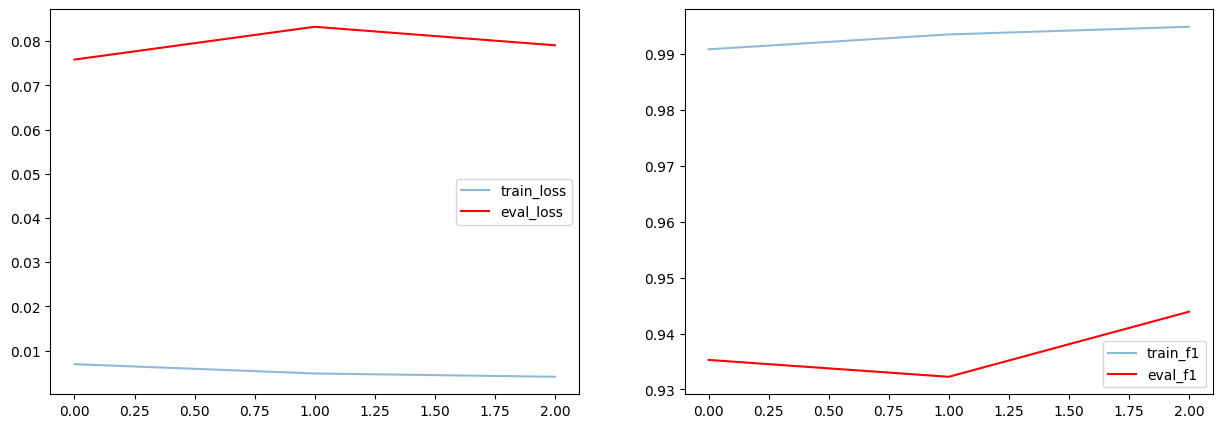

 20%|█▉        | 92/469 [00:29<01:59,  3.17it/s]


KeyboardInterrupt: ignored

In [ ]:
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
    model, train_loader, valid_loader, optimizer, num_epochs)

In [ ]:
print('Final validation f1-score:', valid_f1[-1][1])

Final validation f1-score: 0.9351818830242511


Почему-то обучение перезапустилось, однако loss-ы и f1-меры сохранились, поэтому графики вывожу в ячейке ниже

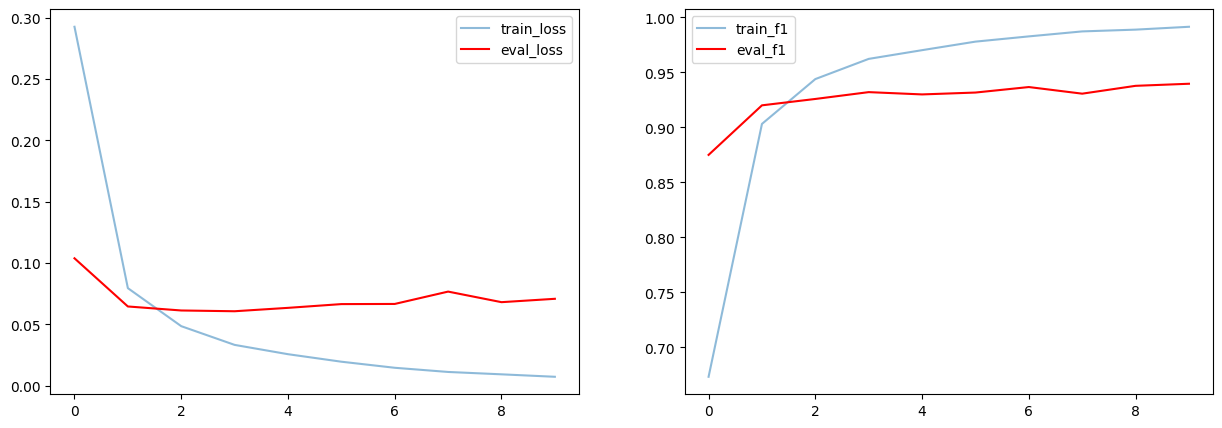

Final validation f1-score: 0.939629035134653


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(*zip(*train_losses), alpha=0.5, label='train_loss')
plt.plot(*zip(*valid_losses), color='red', label='eval_loss')
plt.legend()

plt.subplot(122)
plt.plot(*zip(*train_f1), alpha=0.5, label='train_f1')
plt.plot(*zip(*valid_f1), color='red', label='eval_f1')
plt.legend()
plt.show()

print('Final validation f1-score:', valid_f1[-1][1])

### Embedding factorization

Можно заметить, что на данный момент матрица эмбеддингов занимает $V \cdot H = 28996 \cdot 768 = 22.268.928$ параметров. Это целая пятая часть от всей модели! Давайте попробуем с этим что-то сделать. В вариации [ALBERT](https://arxiv.org/pdf/1909.11942.pdf) предлагается факторизовать матрицу эмбеддингов в произведение двух небольших матриц. Таким образом, параметры эмбеддингов будут содержать $V \cdot E + E \cdot H$ элементов, что гораздо меньше, если $H \gg E$. Авторы выбирают $E = 128$, однако ничего не мешает вам взять значение меньше.

__Задание 4 (1 балл)__ Замените слой эмбеддингов на описанную факторизацию и дообучите полученную в предыдущем задании модель. Насколько вам удалось уменьшить число параметров? Если вы все сделали правильно, то F1-мера на валидации не должна опуститься ниже 0.9.

Мы настоятельно рекомендуем переиспользовать код для обучения из предыдущего задания и не создавать новую функцию.

In [ ]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(28996, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
def factorize_matrix(matrix, target_rank):
    U = torch.randn((matrix.size(0), target_rank), requires_grad=True, device=device)
    V = torch.randn((target_rank, matrix.size(1)), requires_grad=True, device=device)

    optimizer = torch.optim.Adam([U, V], lr=1e-2)

    for iteration in range(5000):
        predictions = U @ V
        loss = torch.nn.functional.mse_loss(predictions, matrix)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iteration % 500 == 0:
            print('Epoch:', iteration, 'Loss:', loss.item())

    return U.detach(), V.detach()

In [ ]:
weights = model.bert.embeddings.word_embeddings.weight.detach().clone().requires_grad_(True)
u, v = factorize_matrix(weights, 64)

Epoch: 0 Loss: 63.88004684448242
Epoch: 500 Loss: 0.004791971296072006
Epoch: 1000 Loss: 0.0021484149619936943
Epoch: 1500 Loss: 0.002098150784149766
Epoch: 2000 Loss: 0.0019672054331749678
Epoch: 2500 Loss: 0.0017776769818738103
Epoch: 3000 Loss: 0.0017613054951652884
Epoch: 3500 Loss: 0.0017605574103072286
Epoch: 4000 Loss: 0.001760171726346016
Epoch: 4500 Loss: 0.0017596252728253603


In [ ]:
class CustomEmbeddings(nn.Module):
    def __init__(self, u, v):
        super().__init__()
        self.first = nn.Parameter(u).to(device)
        self.second = nn.Parameter(v).to(device)

    def forward(self, input_ix):
        matrix = self.first @ self.second
        return matrix[input_ix]

In [ ]:
model.bert.embeddings.word_embeddings = CustomEmbeddings(u,v)
print('Number of parameters:', sum([p.numel() for p in model.parameters()]))

Number of parameters: 87362569


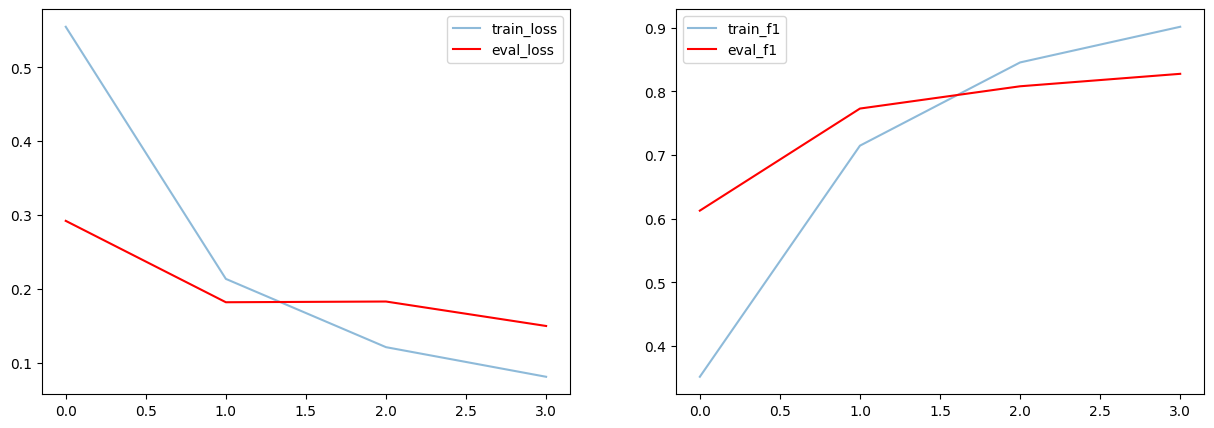

In [ ]:
num_epochs = 4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
    model, train_loader, valid_loader, optimizer, num_epochs, name='factorized_bert.pth')

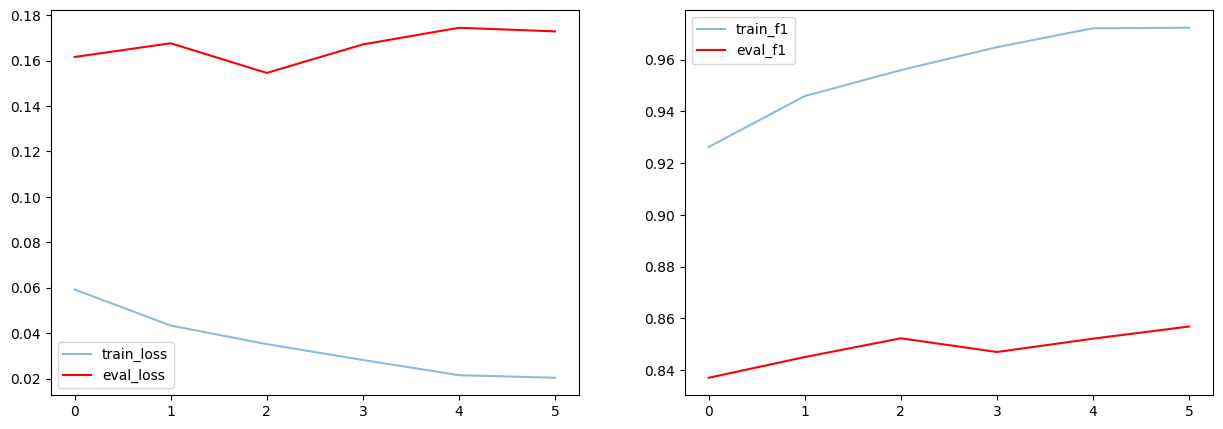

In [ ]:
num_epochs = 6
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
    model, train_loader, valid_loader, optimizer, num_epochs)

Стоит заметить, что я использовал 64, а не 128, как было советовано, поэтому качество подкачало.

In [ ]:
print('Final validation f1-score:', valid_f1[-1][1])

Final validation f1-score: 0.8568111800687591


Откат назад

In [ ]:
#model.bert.embeddings.word_embeddings = nn.Embedding(28996, 768, padding_idx=0)
#model.load_state_dict(torch.load('bert.pth'))

### Дистилляция знаний

Дистилляция знаний – это парадигма обучения, в которой знания модели-учителя дистиллируются в модель-ученика. Учеником может быть произвольная модель меньшего размера, решающая ту же задачу. При дистилляции используются два функционала ошибки:

1. Стандартная кросс-энтропия.
1. Функция, задающая расстояние между распределениями предсказаний учителя и ученика. Чаще всего используют кросс-энтропию или KL-дивергенцию.

При этом для того, чтобы распределение предсказаний учителя не было таким вырожденным используют softmax с температурой больше 1, например, 2 или 5.

<img src="https://intellabs.github.io/distiller/imgs/knowledge_distillation.png">

__Задание 5 (1 балл)__ Реализуйте метод дистилляции знаний, изображенный на картинке. Для подсчета ошибки между предсказаниями ученика и учителя используйте KL-дивергенцию (`nn.KLDivLoss(reduction="batchmean")`). В качестве учителя используйте дообученный BERT из задания 3. В качестве ученика вы можете взять произвольную необученную модель с размером около 40M параметров. Не забудьте про warmup!

In [ ]:
def train_student(model_teacher, model_student, train_loader, valid_loader,
                  opt, scheduler, num_epochs,
                  div_loss_fn=nn.KLDivLoss(reduction="batchmean", log_target=True),
                  div_loss_temp=2,
                  kl_lambda=1.0,
                  student_loss_fn=cross_entropy,
                  name='student.pth'):
    train_losses = []
    train_f1 = []
    valid_f1 = []
    model_teacher.eval()
    for i in range(num_epochs):
        model_student.train()
        train_epoch_loss = 0.
        all_train_predictions = []
        all_train_labels = []
        train_num = 0
        for batch in tqdm(train_loader):
            X = batch['input_ids'].to(device)
            y = batch['labels'].to(device)
            preds = model_student(X)

            student_loss = student_loss_fn(preds.view(-1, len(tag2id)), y.view(-1))
            with torch.no_grad():
                teacher_preds = model_teacher(X)
            #print('\n\nFirst:', F.log_softmax(preds.view(-1, len(tag2id))/div_loss_temp, dim=-1).shape, '\n\nSecond:', F.log_softmax(teacher_preds.logits.view(-1, len(tag2id))/div_loss_temp, dim=-1).shape)
            kl_loss = div_loss_fn(
                F.log_softmax(preds.view(-1, len(tag2id))/div_loss_temp, dim=-1),
                F.log_softmax(teacher_preds.logits.view(-1, len(tag2id))/div_loss_temp, dim=-1)
            )
            #print('\nLoss:', kl_loss.item())
            loss = student_loss + kl_lambda * kl_loss

            opt.zero_grad()
            loss.backward()
            opt.step()
            scheduler.step()

            train_epoch_loss += loss.item()
            train_num += 1

            predicted_classes = torch.argmax(preds, dim=-1)
            predicted_tokens, labels = ids2tokens(predicted_classes, y)
            all_train_predictions += predicted_tokens
            all_train_labels += labels

        train_losses.append((i, train_epoch_loss / train_num))
        train_f1.append((i, f1_score(all_train_labels, all_train_predictions)))

        with torch.no_grad():
            model_student.eval()
            all_valid_predictions = []
            all_valid_labels = []
            valid_num = 0
            for batch in tqdm(valid_loader):
                X = batch['input_ids'].to(device)
                y = batch['labels'].to(device)
                preds = model_student(X)

                valid_num += 1

                predicted_classes = torch.argmax(preds, dim=-1)
                predicted_tokens, labels = ids2tokens(predicted_classes, y)
                all_valid_predictions += predicted_tokens
                all_valid_labels += labels

            valid_f1.append((i, f1_score(all_valid_labels, all_valid_predictions)))

        clear_output(True)
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.plot(*zip(*train_losses), color='blue', label='train_loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(*zip(*train_f1), alpha=0.5, label='train_f1')
        plt.plot(*zip(*valid_f1), color='red', label='eval_f1')
        plt.legend()
        plt.show()

        torch.save(model.state_dict(), name)
    return train_losses, train_f1, valid_f1

In [ ]:
from transformers import DistilBertConfig, DistilBertModel
from transformers import get_linear_schedule_with_warmup

class CustomDistilBERTModel(nn.Module):
    def __init__(self, num_labels=len(tag2id), hidden_size=768):
        super().__init__()
        config = DistilBertConfig(
            vocab_size=28996,
            dim=hidden_size,
            nhead=12,
            num_layers=6
        )
        self.distilbert = DistilBertModel(config)
        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        logits = self.fc(hidden_states)
        return logits

model_student = CustomDistilBERTModel(hidden_size=516).to(device)
print('Student Number of parameters:', sum([p.numel() for p in model_student.parameters()]))

Student Number of parameters: 40690077


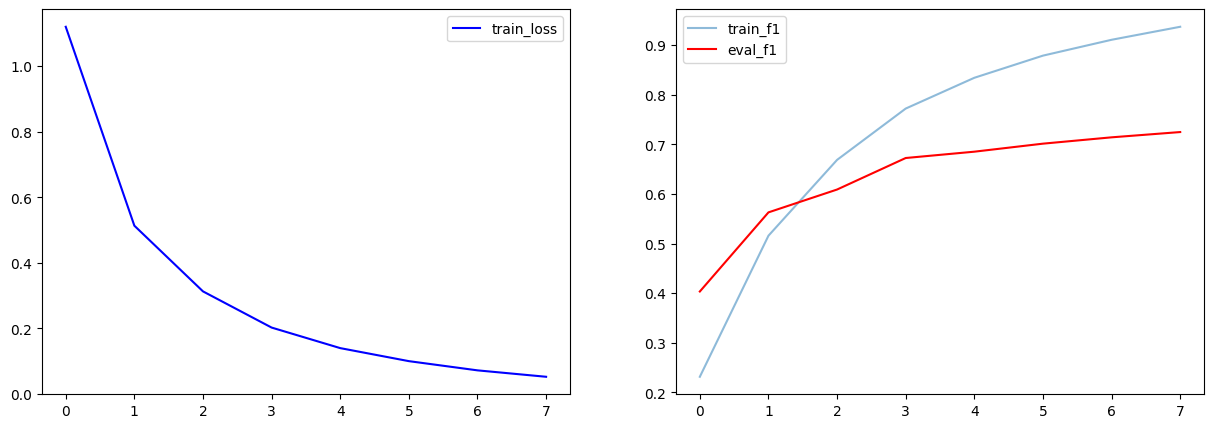

  7%|▋         | 35/469 [00:07<01:37,  4.45it/s]


KeyboardInterrupt: ignored

In [ ]:
num_epochs = 15
optimizer = torch.optim.Adam(model_student.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=700, num_training_steps=7000)
train_losses, train_f1, valid_f1 = train_student(
    model, model_student, train_loader, valid_loader, optimizer, scheduler, num_epochs)

## Соревнование (до 10 баллов)

Ваша задача – обучить модель с размером __не больше 20М параметров__ для задачи NER. При этом можно пользоваться предобученным `bert-base-cased`, но больше ничем.

Соревнование будет проходить аналогично соревнованию из второго домашнего задания. Ваши посылки вы должны будете отправлять тг-боту [@nlp_hw4_bot](t.me/nlp_hw4_bot), а он будет считать значения F1 на публичном и приватном датасетах и записывать результат в [табличку](https://docs.google.com/spreadsheets/d/1rILRI16VxgztwlfqR2kPZ3MxlJkerz6iEr5Kx9yrOLA/edit#gid=0).

Для формирования посылки вам нужно будет создать папку на dropbox, положить в нее файл `model.py` с классом модели `Model` и веса `weights.pt`, а затем отправить боту ссылку на эту папку, доступную к чтению. Бот будет импортировать модель и загружать веса:
```
module = __import__('model', globals(), locals(), ['Model'], 0)
model = module.Model()
model.load_state_dict(torch.load('weights.pt', map_location=torch.device('cpu')))
```

При тестировании модель будет получать на вход `input_ids` и `attention_mask`, а на выход должна возвращать трехмерный тензор с вероятностями меток для каждого токена в батче. Класс `Model` должен содержать атрибут `id2label` совпадающий с тем, который задан в конфиге модели `model.config.id2label`. Это нужно для того, чтобы id тэгов мапились в нужные названия тэгов, так как они могут отличаться у разных решений.


__Обязательм условием__ участия в соревновании является отчет о проделанной работе в формате pdf, в котором вы должны описать опробованные методы с результатами. За отчет выставляется максимум до __2 баллов__ на усмотрение проверяющего. В случае отсутствия отчета баллы за соревнование __обнуляются__.

После дедлайна по домашке будут выложен _приватный_ лидерборд, по которому и будут выставляться баллы за соревнования. За место в лидерборде можно получить до __8__ баллов, но только при условии, если вы получили больше __0.8__ на _публичном_ лидерборде, в противном случае баллы выставляться не будут.
$$
\text{число баллов} = 8\frac{(N - r + 1)}{N},
$$
где $r$ – место в лидерборде, а $N$ - число участников со значением F1 на _публичном_ лидерборде не меньше __0.8__.


На сервере установлена версия библиотеки `transformers==4.34.0`.
В разных версиях может отличаться вид хранения весов, поэтому рекомендуем установить себе такую же версию, чтобы избежать ошибок при загрузке модели.

# Попробуем добиться снижения количества параметров при помощи обучения ученика

In [ ]:
weights = model_student.distilbert.embeddings.word_embeddings.weight.detach().clone().requires_grad_(True)
u, v = factorize_matrix(weights, 128)
model_student.distilbert.embeddings.word_embeddings = CustomEmbeddings(u,v)
print('Number of parameters:', sum([p.numel() for p in model_student.parameters()]))

Epoch: 0 Loss: 127.46048736572266
Epoch: 500 Loss: 0.0019641127437353134
Epoch: 1000 Loss: 0.0004085389955434948
Epoch: 1500 Loss: 0.0003713829501066357
Epoch: 2000 Loss: 0.00036677755997516215
Epoch: 2500 Loss: 0.0003659453068394214
Epoch: 3000 Loss: 0.0003658371861092746
Epoch: 3500 Loss: 0.00036581995664164424
Epoch: 4000 Loss: 0.0003658435307443142
Epoch: 4500 Loss: 0.000365850719390437
Number of parameters: 29505677


In [ ]:
model_student = CustomDistilBERTModel(hidden_size=264).to(device)
print('Student Number of parameters:', sum([p.numel() for p in model_student.parameters()]))

Student Number of parameters: 19230513


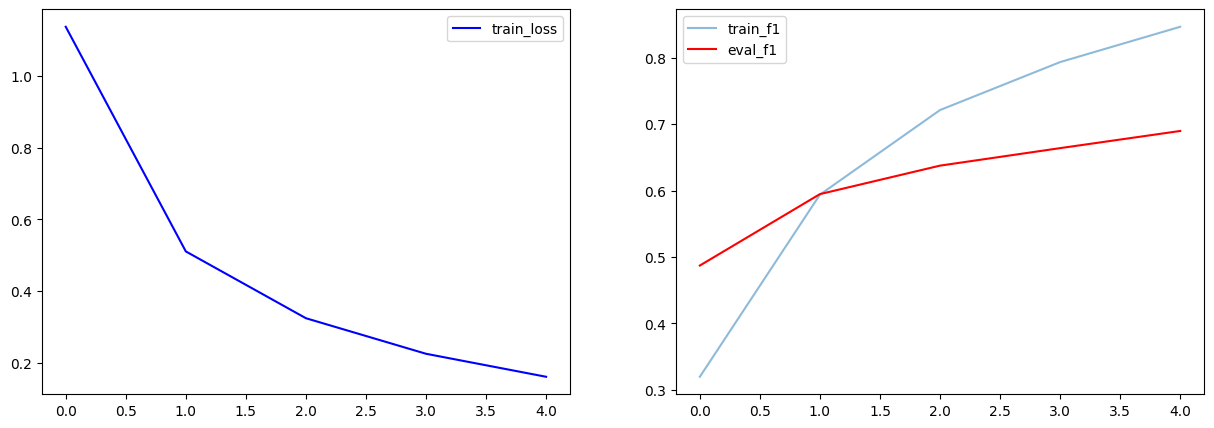

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 10
optimizer = torch.optim.Adam(model_student.parameters(), lr=3e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=400, num_training_steps=4000)
train_losses, train_f1, valid_f1 = train_student(
    model, model_student, train_loader, valid_loader, optimizer, scheduler, num_epochs, kl_lambda=2.0)

Как видим, финальное качество оказалось в районе 0.7

# Теперь попробуем уменьшить количество параметров, разложив каждую матрицу параметров на произведение двух матриц маленького ранга и дообучения получившейся модели

# Новый раздел

In [ ]:
weights = model_student.distilbert.embeddings.word_embeddings.weight.detach().clone().requires_grad_(True)
u, v = factorize_matrix(weights, 128)
model_student.distilbert.embeddings.word_embeddings = CustomEmbeddings(u,v)
print('Number of parameters:', sum([p.numel() for p in model_student.parameters()]))

Epoch: 0 Loss: 127.38890838623047
Epoch: 500 Loss: 0.0019219859968870878
Epoch: 1000 Loss: 0.0003733184712473303
Epoch: 1500 Loss: 0.0003491390962153673
Epoch: 2000 Loss: 0.00034776603570207953
Epoch: 2500 Loss: 0.00034772331127896905
Epoch: 3000 Loss: 0.0003477366699371487
Epoch: 3500 Loss: 0.00034774685627780855
Epoch: 4000 Loss: 0.00034773844527080655
Epoch: 4500 Loss: 0.0003478043363429606
Number of parameters: 19062617


In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, u, v):
        super().__init__()
        self.first = nn.Parameter(u).to(device)
        self.second = nn.Parameter(v).to(device)

    def forward(self, input_ix):
        matrix = self.first @ self.second
        return input_ix @ matrix.T

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
for layer in model.bert.encoder.layer:
    weights = layer.attention.self.query.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.query = CustomLinear(u,v)

    weights = layer.attention.self.key.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.key = CustomLinear(u,v)

    weights = layer.attention.self.value.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.value = CustomLinear(u,v)

    weights = layer.attention.output.dense.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.output.dense = CustomLinear(u,v)

    weights = layer.intermediate.dense.weight
    u, v = factorize_matrix(weights, 112)
    layer.intermediate.dense = CustomLinear(u,v)

    weights = layer.output.dense.weight
    u, v = factorize_matrix(weights, 112)
    layer.output.dense = CustomLinear(u,v)

weights = model.bert.embeddings.word_embeddings.weight
u, v = factorize_matrix(weights, 128)
model.bert.embeddings.word_embeddings = CustomEmbeddings(u,v)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', id2label=id2tag, label2id=tag2id).to(device)
model.load_state_dict(torch.load('bert.pth'))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
print('Number of parameters:', sum([p.numel() for p in model.parameters()]))

Number of parameters: 19290377


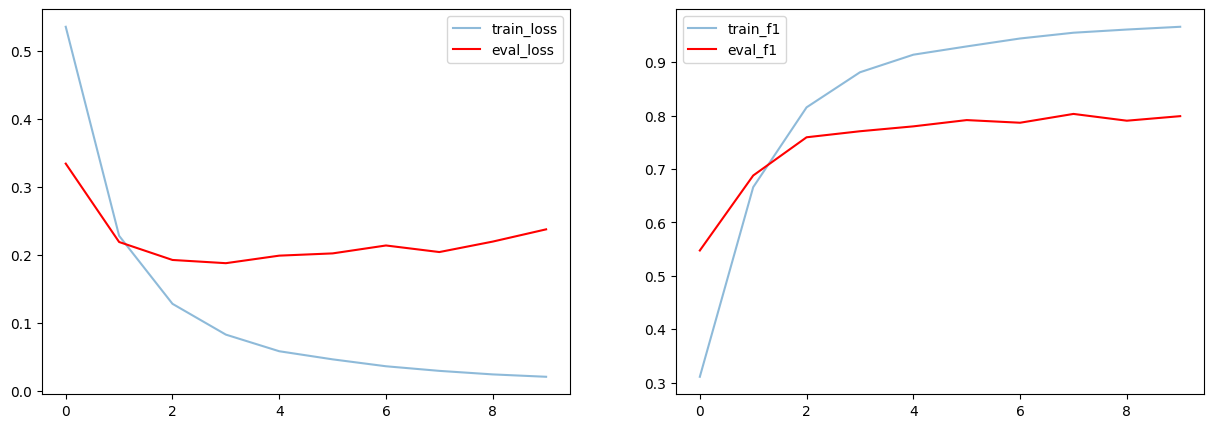

In [ ]:
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
    model, train_loader, valid_loader, optimizer, num_epochs, name='bert_lora.pth')

In [ ]:
print('Final validation f1-score:', valid_f1[-1][1])

Final validation f1-score: 0.7989257253555233


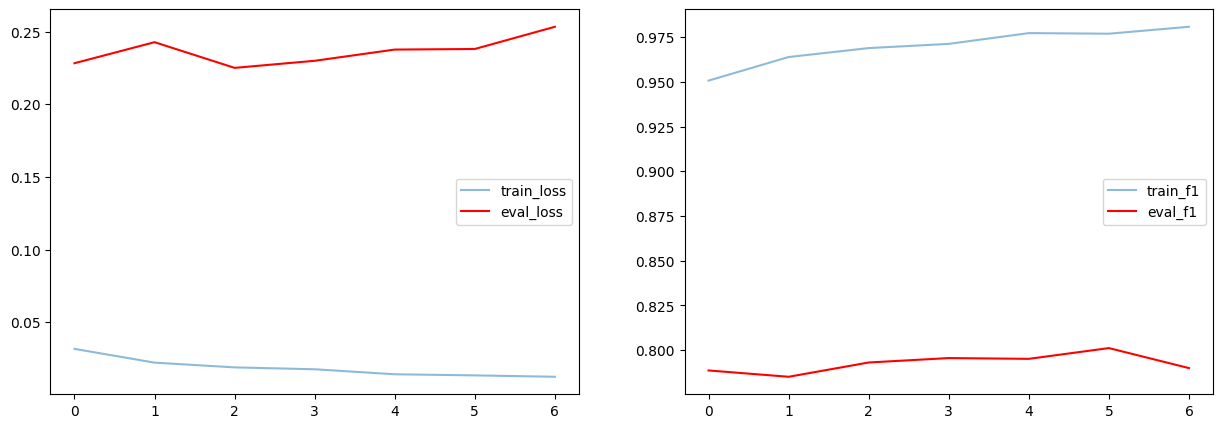

In [ ]:
weights = model.bert.embeddings.word_embeddings.weight
u, v = factorize_matrix(weights, 128)
model.bert.embeddings.word_embeddings = CustomEmbeddings(u,v)

num_epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
        model, train_loader, valid_loader, optimizer, num_epochs, name='bert_lora.pth')

for layer in model.bert.encoder.layer:
    weights = layer.attention.self.query.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.query = CustomLinear(u,v)

    weights = layer.attention.self.key.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.key = CustomLinear(u,v)

    weights = layer.attention.self.value.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.self.value = CustomLinear(u,v)

    weights = layer.attention.output.dense.weight
    u, v = factorize_matrix(weights, 64)
    layer.attention.output.dense = CustomLinear(u,v)

    weights = layer.intermediate.dense.weight
    u, v = factorize_matrix(weights, 112)
    layer.intermediate.dense = CustomLinear(u,v)

    weights = layer.output.dense.weight
    u, v = factorize_matrix(weights, 112)
    layer.output.dense = CustomLinear(u,v)

    num_epochs = 1
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    train_losses, valid_losses, train_f1, valid_f1 = train(
        model, train_loader, valid_loader, optimizer, num_epochs, name='bert_lora.pth')

num_epochs = 7
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_losses, valid_losses, train_f1, valid_f1 = train(
        model, train_loader, valid_loader, optimizer, num_epochs, name='bert_lora.pth')

In [ ]:
print('Final validation f1-score:', valid_f1[-1][1])

In [ ]:
torch.save(model.state_dict(), "weights.pt")

In [ ]:
import torch
a = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])
a.reshape((4,2))

tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])

Итого, качество удалось поднять до 0.8 при том же количестве параметров.